In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [3]:
def evaluate_lagrange(x_val, nodes, values):
    n = len(nodes) - 1
    lagrange_val = 0.0
    for j in range(n + 1):
        basis = 1.0
        for m in range(n + 1):
            if m != j:
                basis *= (x_val - nodes[m]) / (nodes[j] - nodes[m])
        lagrange_val += values[j] * basis
    return lagrange_val
    

In [4]:
def evaluate_hermite(x_val, nodes, values, derivatives):
    n = len(nodes) - 1
    hermite_val = 0.0
    for j in range(n + 1):
        basis = 1.0
        for m in range(n + 1):
            if m != j:
                basis *= (x_val - nodes[m]) / (nodes[j] - nodes[m])
        basis_derivative = 0.0
        for m in range(n + 1):
            if m != j:
                prod = 1.0
                for k in range(n + 1):
                    if k != j and k != m:
                        prod *= (x_val - nodes[k]) / (nodes[j] - nodes[k])
                basis_derivative += prod / (nodes[j] - nodes[m])
        
        Qj = (1 - 2 * (x_val - nodes[j]) * basis_derivative) * (basis ** 2)
        Rj = (x_val - nodes[j]) * (basis ** 2)
        hermite_val += values[j] * Qj + derivatives[j] * Rj
    return hermite_val
    

In [5]:
def cubic_poly_evaluator(M_i, M_ip1, x_i, x_ip1, f_x_i, f_x_ip1):
    h = x_ip1 - x_i
    C = (f_x_i / h) - (M_i * h / 6)
    D = (f_x_ip1 / h) - (M_ip1 * h / 6)
    
    def poly(x):
        return (((x_ip1 - x)**3) * M_i + ((x - x_i)**3) * M_ip1) / (6 * h) + C * (x_ip1 - x) + D * (x - x_i)
    
    return poly


In [7]:
def find_interval_index(nodes, x_val):
    for i in range(len(nodes) - 1):
        if nodes[i] <= x_val <= nodes[i + 1]:
            return i
    return len(nodes) - 2


In [8]:

def compute_spline_M(nodes, values, clamped=None):
    n = len(nodes) - 1
    h = np.diff(nodes)
    A = np.zeros((n + 1, n + 1))
    rhs = np.zeros(n + 1)
    
    if clamped is None:
        A[0, 0] = 1
        A[n, n] = 1
        for i in range(1, n):
            A[i, i - 1] = h[i - 1] / 6
            A[i, i] = (h[i - 1] + h[i]) / 3
            A[i, i + 1] = h[i] / 6
            rhs[i] = (values[i + 1] - values[i]) / h[i] - (values[i] - values[i - 1]) / h[i - 1]
    else:
        A[0, 0] = 2 * h[0]
        A[0, 1] = h[0]
        rhs[0] = 6 * ((values[1] - values[0]) / h[0] - clamped[0])
        
        A[n, n - 1] = h[n - 1]
        A[n, n] = 2 * h[n - 1]
        rhs[n] = 6 * (clamped[1] - (values[n] - values[n - 1]) / h[n - 1])
        
        for i in range(1, n):
            A[i, i - 1] = h[i - 1]
            A[i, i] = 2 * (h[i - 1] + h[i])
            A[i, i + 1] = h[i]
            rhs[i] = 6 * ((values[i + 1] - values[i]) / h[i] - (values[i] - values[i - 1]) / h[i - 1])
    
    M = np.linalg.solve(A, rhs)
    return M



In [9]:
def evaluate_cubic_spline(nodes, values, x_eval, clamped=None):
    """
    Evaluate the cubic spline interpolant at the points in x_eval.
    
    Parameters:
        nodes (np.array): Interpolation nodes.
        values (np.array): Function values at the nodes.
        x_eval (np.array): Points where the spline is evaluated.
        clamped (list or None): If provided, endpoint derivative values for a clamped spline.
        
    Returns:
        np.array: Spline evaluated at x_eval.
    """
    n = len(nodes) - 1
    M = compute_spline_M(nodes, values, clamped)
    spline_vals = np.zeros_like(x_eval)
    
    for idx, x in enumerate(x_eval):
        interval = find_interval_index(nodes, x)
        x_left, x_right = nodes[interval], nodes[interval + 1]
        f_left, f_right = values[interval], values[interval + 1]
        poly = cubic_poly_evaluator(M[interval], M[interval + 1], x_left, x_right, f_left, f_right)
        spline_vals[idx] = poly(x)
    
    return spline_vals

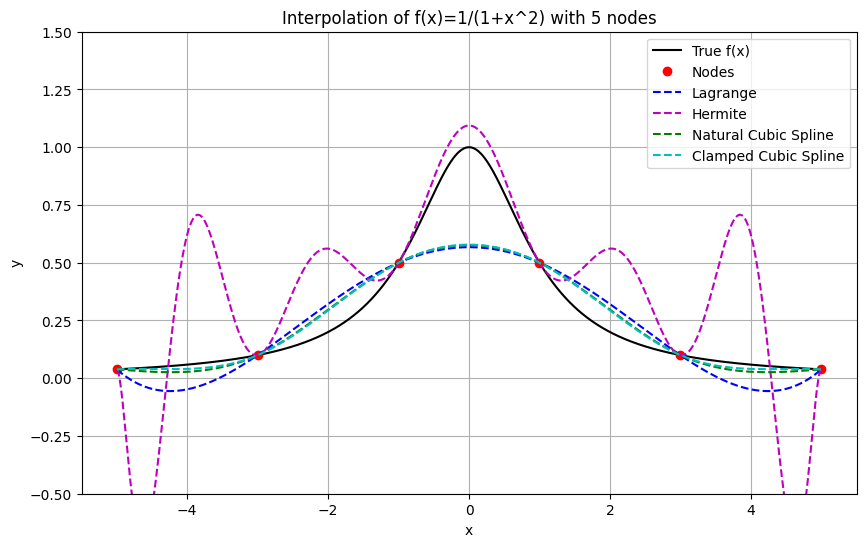

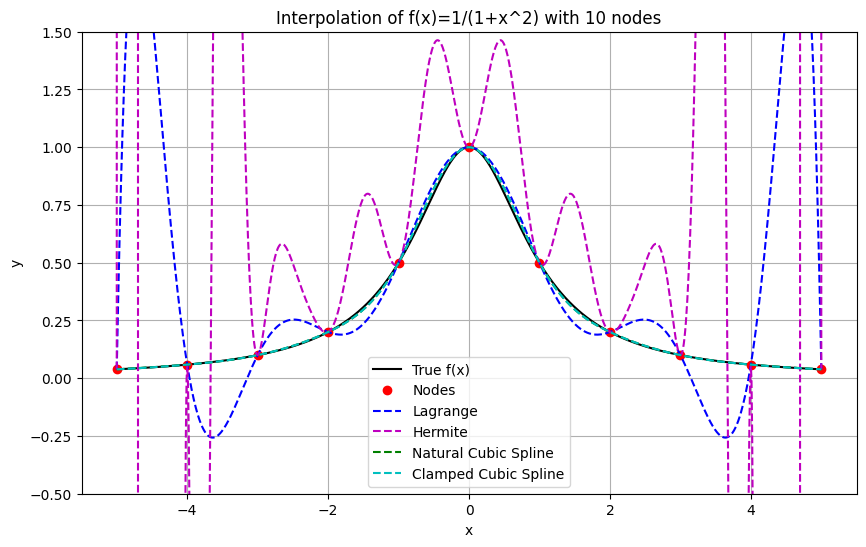

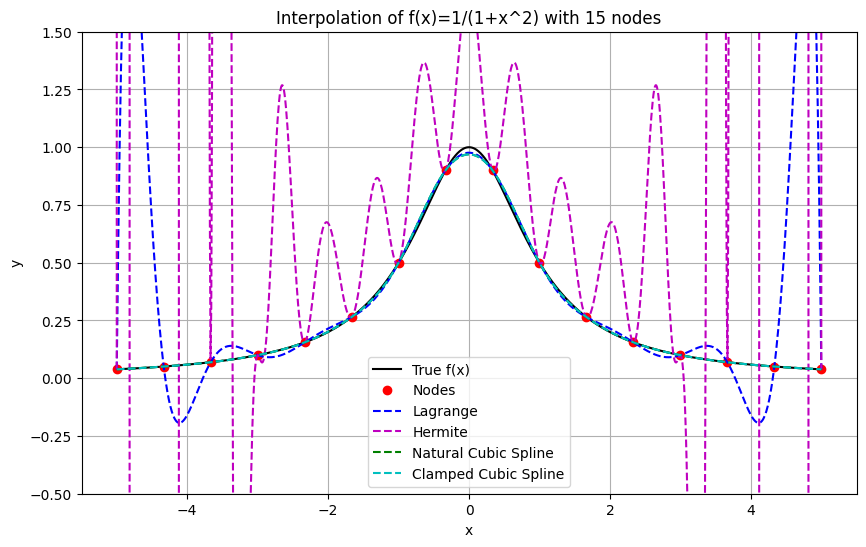

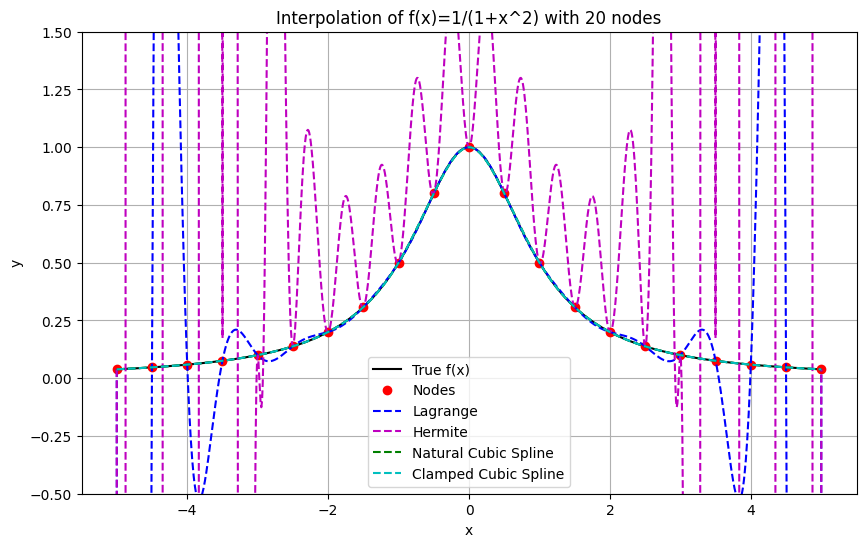

In [18]:
f = lambda x: 1 / (1 + x**2)
df = lambda x: -2 * x / (1 + x**2)**2

# Define the domain for interpolation
a, b = -5, 5

# Define evaluation points for plotting
num_eval = 1000
x_eval = np.linspace(a, b, num_eval)
y_true = f(x_eval)

# Loop over different numbers of nodes (number of subintervals)
for num_subintervals in [5, 10, 15, 20]:
    # Create equispaced nodes
    x_nodes = np.linspace(a, b, num_subintervals + 1)
    y_nodes = f(x_nodes)
    dy_nodes = df(x_nodes)

    y_lagrange = np.array([evaluate_lagrange(x, x_nodes, y_nodes) for x in x_eval])
    y_hermite = np.array([evaluate_hermite(x, x_nodes, y_nodes, dy_nodes) for x in x_eval])
    y_natural_spline = evaluate_cubic_spline(x_nodes, y_nodes, x_eval, clamped=None)
    y_clamped_spline = evaluate_cubic_spline(x_nodes, y_nodes, x_eval, clamped=[df(a), df(b)])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_eval, y_true, 'k-', label='f(x)')
    plt.plot(x_nodes, y_nodes, 'ro', label='Nodes')
    plt.plot(x_eval, y_lagrange, 'b--', label='Lagrange')
    plt.plot(x_eval, y_hermite, 'm--', label='Hermite')
    plt.plot(x_eval, y_natural_spline, 'g--', label='Natural Cubic Spline')
    plt.plot(x_eval, y_clamped_spline, 'c--', label='Clamped Cubic Spline')
    plt.title(f'Interpolation of f(x)=1/(1+x^2) with {num_subintervals} nodes')
    plt.ylim(bottom = -0.5, top =1.5)
    plt.legend()
    plt.grid(True)
    plt.show()


# Question 2

In [29]:
def chebyshev_nodes(a, b, N):
    k = np.arange(N)
    x_cheb = np.cos((2*k + 1) * np.pi / (2*N))
    return 0.5*(a + b) + 0.5*(b - a)*x_cheb

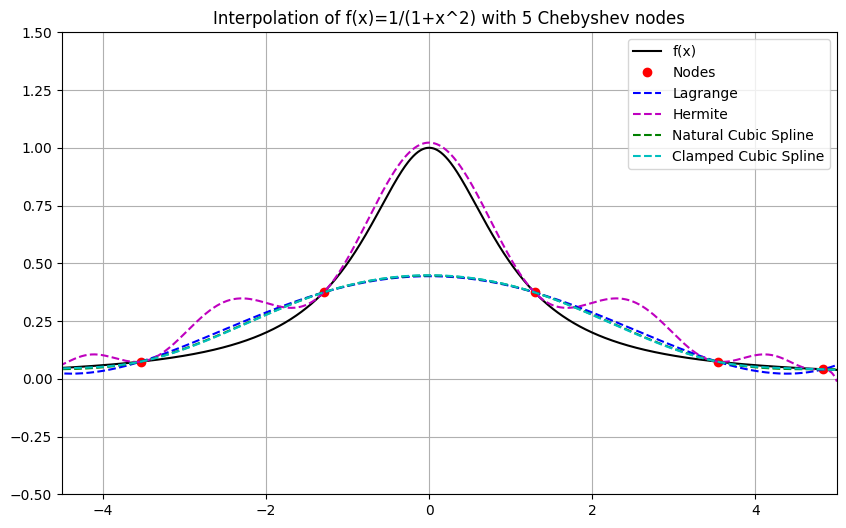

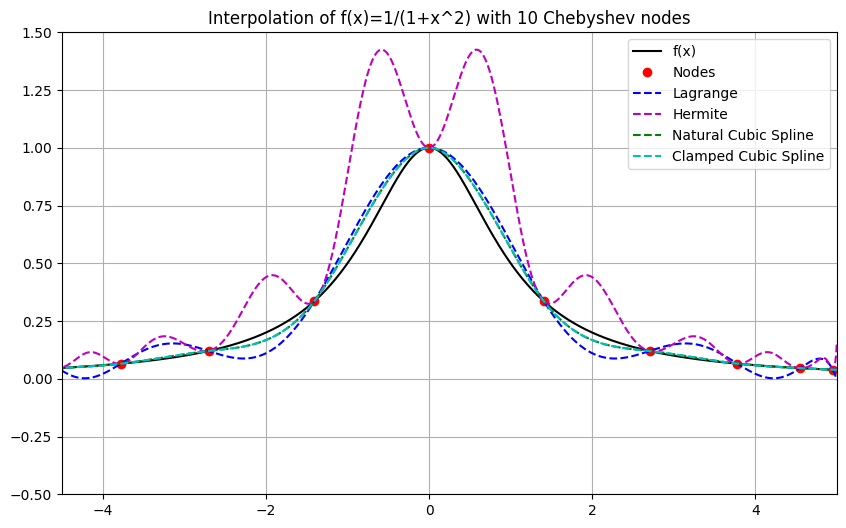

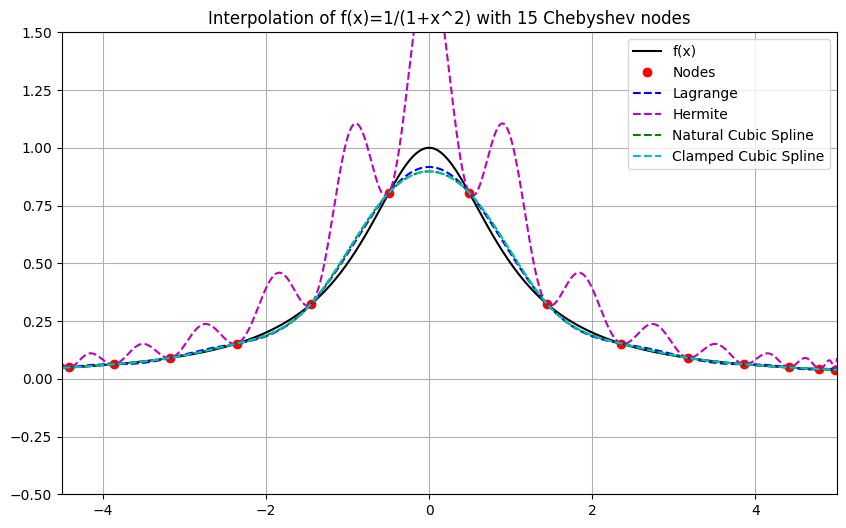

In [36]:
# Function to generate Chebyshev nodes on [a,b]
def chebyshev_nodes(a, b, N):
    k = np.arange(N)
    # Chebyshev nodes in [-1,1]
    x_cheb = np.cos((2*k + 1) * np.pi / (2*N))
    # Scale to [a, b]
    return 0.5*(a + b) + 0.5*(b - a)*x_cheb

# Define the function and its derivative
f = lambda x: 1 / (1 + x**2)
df = lambda x: -2 * x / (1 + x**2)**2

# Define the domain for interpolation
a, b = -5, 5

# Define evaluation points for plotting
num_eval = 1000
x_eval = np.linspace(a, b, num_eval)
y_true = f(x_eval)

# Loop over different numbers of nodes (number of subintervals)
for num_subintervals in [5, 10, 15, 20]:
    N_nodes = num_subintervals + 1
    # Create Chebyshev nodes instead of equispaced nodes
    x_nodes = chebyshev_nodes(a, b, N_nodes)
    # Sort the nodes since Chebyshev nodes are generated in descending order
    x_nodes = np.sort(x_nodes)
    y_nodes = f(x_nodes)
    dy_nodes = df(x_nodes)

    y_lagrange = np.array([evaluate_lagrange(x, x_nodes, y_nodes) for x in x_eval])
    y_hermite = np.array([evaluate_hermite(x, x_nodes, y_nodes, dy_nodes) for x in x_eval])
    y_natural_spline = evaluate_cubic_spline(x_nodes, y_nodes, x_eval, clamped=None)
    y_clamped_spline = evaluate_cubic_spline(x_nodes, y_nodes, x_eval, clamped=[df(a), df(b)])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_eval, y_true, 'k-', label='f(x)')
    plt.plot(x_nodes, y_nodes, 'ro', label='Nodes')
    plt.plot(x_eval, y_lagrange, 'b--', label='Lagrange')
    plt.plot(x_eval, y_hermite, 'm--', label='Hermite')
    plt.plot(x_eval, y_natural_spline, 'g--', label='Natural Cubic Spline')
    plt.plot(x_eval, y_clamped_spline, 'c--', label='Clamped Cubic Spline')
    plt.title(f'Interpolation of f(x)=1/(1+x^2) with {num_subintervals} Chebyshev nodes')
    plt.ylim(-0.5, 1.5)
    plt.xlim(-4.5,5)
    plt.legend()
    plt.grid(True)
    plt.show()